In [1]:
from pandas import Series, DataFrame
import pandas as pd
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("bgg_db_2018_01.csv")
print df.shape
df.head()

(4999, 20)


,rank,bgg_url,game_id,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,image_url,age,mechanic,owned,category,designer,weight
0,1,https://boardgamegeek.com/boardgame/174430/glo...,174430,Gloomhaven,1,4,150,90,150,2017,9.01310,8.52234,9841,https://cf.geekdo-images.com/images/pic2437871...,12,"Action / Movement Programming, Co-operative Pl...",18217,"Adventure, Exploration, Fantasy, Fighting, Min...",Isaac Childres,3.7720
1,2,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66575,8.49837,23489,https://cf.geekdo-images.com/images/pic2452831...,13,"Action Point Allowance System, Co-operative Pl...",38105,"Environmental, Medical","Rob Daviau, Matt Leacock",2.8056
2,3,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.65702,8.32401,10679,https://cf.geekdo-images.com/images/pic2663291...,14,"Action Point Allowance System, Auction/Bidding...",14147,"Card Game, Civilization, Economic",Vlaada Chv�til,4.3538
3,4,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180,120,180,2005,8.35188,8.21012,29923,https://cf.geekdo-images.com/images/pic361592.jpg,13,"Area Control / Area Influence, Campaign / Batt...",41094,"Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5446
4,5,https://boardgamegeek.com/boardgame/167791/ter...,167791,Terraforming Mars,1,5,120,120,120,2016,8.38331,8.17328,20468,https://cf.geekdo-images.com/images/pic3536616...,12,"Card Drafting, Hand Management, Tile Placement...",26145,"Economic, Environmental, Industry / Manufactur...",Jacob Fryxelius,3.2465


## Dataset cleaning

### Analyzing avg_rating and geek_rating variable

In [3]:
#Excluding boardgames which do not have atleast than 100 votes
df = df[df['num_votes']>=100]
print df.shape
print df['avg_rating'].quantile([0.5,0.75,0.95,0.99])

#creating detractors and promoters for avg_rating (since its a survey result)
conditions = [
    (df['avg_rating'] <= df['avg_rating'].quantile(0.95)),
    (df['avg_rating'] > df['avg_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
df['avg_rating_range'] = np.select(conditions, choices)
df['avg_rating_range'].value_counts()

#creating detractors and promoters for geek_rating (since its a survey result)
conditions = [
    (df['geek_rating'] <= df['geek_rating'].quantile(0.95)),
    (df['geek_rating'] > df['geek_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
df['geek_rating_range'] = np.select(conditions, choices)
df['geek_rating_range'].value_counts()

(4903, 20)
0.50    6.883800
0.75    7.305275
0.95    7.929081
0.99    8.326149
Name: avg_rating, dtype: float64


detractors    4657
promoters      246
Name: geek_rating_range, dtype: int64

## EDA

### Number of players

Text(0.5,0,'Min_players')

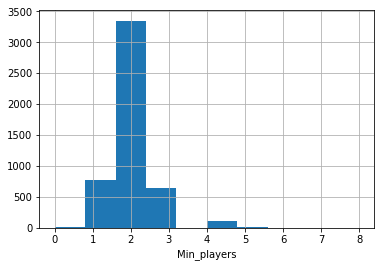

In [4]:
df['min_players'].hist()
xlabel('Min_players')

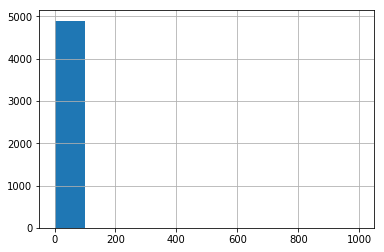

In [5]:
#max_players has a long tail
df['max_players'].hist()

Text(0.5,0,'Max players')

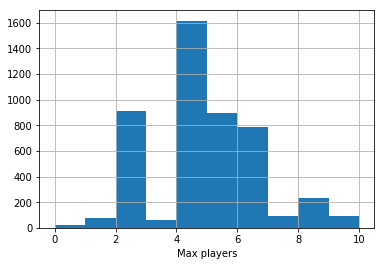

In [6]:
#checking the popular categories by condensing the tail
dfx = df[df['max_players']<=10]
dfx['max_players'].hist()
xlabel("Max players") #peak at 4 and 6

In [7]:
#creating categories single player, and multiplayer 0-2,1-2, 1-4, 1-6,1-8,>8 based on histograms
conditions = [
    (df['min_players'] <= 1) & (df['max_players'] <= 1) ,
    (df['min_players'] <= 1) & (df['max_players'] <= 2) ,
    (df['min_players'] <= 1) & (df['max_players'] <= 4) ,
    (df['min_players'] <= 1) & (df['max_players'] <= 6) ,
    (df['min_players'] <= 1) & (df['max_players'] <= 8) ,
    (df['min_players'] == 2) & (df['max_players'] <= 2) ,
    (df['min_players'] == 2) & (df['max_players'] <= 4) ,
    (df['min_players'] == 2) & (df['max_players'] <= 6) ,
    (df['min_players'] == 2) & (df['max_players'] <= 8) ,
    (df['min_players'] > 2) & (df['max_players'] <= 4) ,
    (df['min_players'] > 2) & (df['max_players'] <= 6) ,
    (df['min_players'] > 2) & (df['max_players'] <= 8) ,
    (df['max_players'] > 8) ,
]
choices = ['single_player', 'a','b','c','d','two_player','f','g','h','i','j','k','l']
df['num_players'] = np.select(conditions, choices)
df['num_players'].value_counts()

f                1244
g                1047
two_player        799
j                 433
b                 316
l                 214
c                 206
h                 175
a                 122
i                 121
k                 111
single_player      81
d                  34
Name: num_players, dtype: int64

In [8]:
#Checking avg_rating and geek_rating NPS for player range
cdf = pd.crosstab(df['num_players'],df['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('NPS',ascending = False)

cdf = pd.crosstab(df['num_players'],df['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('NPS',ascending = False)

#two player games are most popular followed by 1 to 4 players
# Key:
# a: 1 to 2
# b: 1 to 4
# c: 1 to 6
# d: 1 to 8
# f: 2 to 4
# g: 2 to 6
# h: 2 to 8
# i: 2+ to 4
# j: 2+ to 6
# k: 2+ to 8
# l: 8+


avg_rating_range  detractors  promoters        NPS
num_players                                       
two_player         15.696801  27.642276  11.945476
b                   5.883616  17.073171  11.189555
a                   2.147305   8.943089   6.795784
single_player       1.503114   4.471545   2.968431
c                   4.101353   6.097561   1.996208
d                   0.687138   0.813008   0.125870
k                   2.319090   1.219512  -1.099577
h                   3.628946   2.439024  -1.189921
i                   2.555293   0.813008  -1.742285
l                   4.466395   2.439024  -2.027370
j                   9.211939   1.626016  -7.585923
f                  25.767662  17.886179  -7.881483
g                  22.031351   8.536585 -13.494765


geek_rating_range,detractors,promoters,NPS
num_players,,,
f,25.037578,31.707317,6.669739
b,6.184239,11.382114,5.197875
c,4.036934,7.317073,3.280140
d,0.644192,1.626016,0.981825
h,3.564527,3.658537,0.094010
g,21.387159,20.731707,-0.655452
a,2.555293,1.219512,-1.335781
single_player,1.739317,0.000000,-1.739317
i,2.555293,0.813008,-1.742285


### Average time

count     4903.000000
mean       108.120538
std        442.747988
min          0.000000
25%         30.000000
50%         60.000000
75%        100.000000
max      22500.000000
Name: avg_time, dtype: float64
0.50     60.0
0.75    100.0
0.95    240.0
0.99    720.0
Name: avg_time, dtype: float64
count    4861.000000
mean       83.510800
std        84.388042
min         0.000000
25%        30.000000
50%        60.000000
75%        90.000000
max       720.000000
Name: avg_time, dtype: float64
0.50     60.0
0.75     90.0
0.95    240.0
0.99    360.0
Name: avg_time, dtype: float64


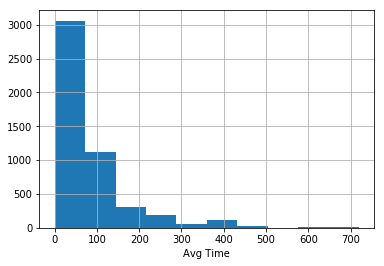

In [9]:
#Average time
print df['avg_time'].describe()
print df['avg_time'].quantile([0.5,0.75,0.95,0.99])
#df['avg_time'].hist()

dfx = df[df['avg_time']<=720]
dfx['avg_time'].hist()
xlabel("Avg Time") #peak at 4 and 6
print dfx['avg_time'].describe()
print dfx['avg_time'].quantile([0.5,0.75,0.95,0.99])

In [10]:
#Bucketing avg_time into 5 buckets:
# Games between 30 mins to 45 mins are most popular
df['avg_time_bucket'] = pd.qcut(df['avg_time'],5)
cdf = pd.crosstab(df['avg_time_bucket'],df['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('avg_time_bucket',ascending = True)

cdf = pd.crosstab(df['avg_time_bucket'],df['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('avg_time_bucket',ascending = True)

avg_rating_range  detractors  promoters        NPS
avg_time_bucket                                   
(-0.001, 30.0]     22.353446  32.113821   9.760375
(30.0, 45.0]       13.205927  48.373984  35.168057
(45.0, 60.0]       15.181447   4.878049 -10.303399
(60.0, 120.0]      17.908525   9.349593  -8.558931
(120.0, 22500.0]   31.350655   5.284553 -26.066102


geek_rating_range,detractors,promoters,NPS
avg_time_bucket,,,
"(-0.001, 30.0]",21.966932,39.430894,17.463963
"(30.0, 45.0]",14.451364,24.796748,10.345384
"(45.0, 60.0]",15.052609,7.317073,-7.735536
"(60.0, 120.0]",17.607902,15.040650,-2.567252
"(120.0, 22500.0]",30.921194,13.414634,-17.506560


#### Age of the game

avg_rating_range  detractors  promoters        NPS
age_bucket                                        
(-0.001, 8.0]      10.994202  29.674797  18.680594
(8.0, 10.0]         8.868370  10.975610   2.107240
(10.0, 12.0]       26.626584  17.886179  -8.740405
(12.0, 13.0]       24.930213   5.284553 -19.645660
(13.0, 21.0]       28.580631  36.178862   7.598230


geek_rating_range,detractors,promoters,NPS
age_bucket,,,
"(-0.001, 8.0]",11.251879,24.796748,13.544869
"(8.0, 10.0]",8.524801,17.479675,8.954873
"(10.0, 12.0]",26.991626,10.975610,-16.016016
"(12.0, 13.0]",24.479279,13.821138,-10.658140
"(13.0, 21.0]",28.752416,32.926829,4.174414


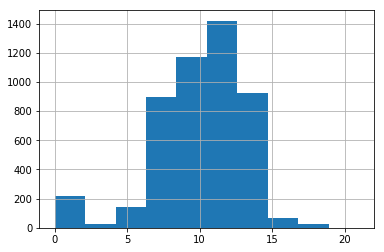

In [11]:
#checking for age
#print df['age'].describe()
#print df['age'].quantile([0.5,0.75,0.95,0.99])
df['age'].hist()

df['age_bucket'] = pd.qcut(df['age'],5)
cdf = pd.crosstab(df['age_bucket'],df['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('age_bucket',ascending = True)
#classics and younger games are loved by game lovers

cdf = pd.crosstab(df['age_bucket'],df['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('age_bucket',ascending = True)

### Weight of the game

avg_rating_range  detractors  promoters        NPS
weight_bucket                                     
(-0.001, 1.6]      19.433111  19.918699   0.485588
(1.6, 2.06]        17.371699  69.918699  52.547001
(2.06, 2.5]        21.215375   7.317073 -13.898302
(2.5, 3.032]       20.571183   1.626016 -18.945167
(3.032, 4.869]     21.408632   1.219512 -20.189120


geek_rating_range,detractors,promoters,NPS
weight_bucket,,,
"(-0.001, 1.6]",19.153962,25.203252,6.049290
"(1.6, 2.06]",18.531243,47.967480,29.436236
"(2.06, 2.5]",20.936225,12.601626,-8.334599
"(2.5, 3.032]",20.163195,9.349593,-10.813602
"(3.032, 4.869]",21.215375,4.878049,-16.337326


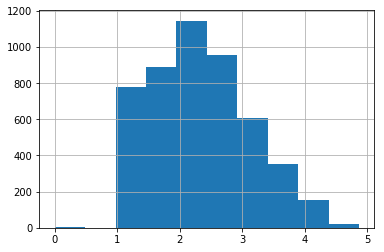

In [12]:
#weight
#Heavier games arent preferred
df['weight'].hist()

df['weight_bucket'] = pd.qcut(df['weight'],5)
cdf = pd.crosstab(df['weight_bucket'],df['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('weight_bucket',ascending = True)
#classics and younger games are loved by game lovers

cdf = pd.crosstab(df['weight_bucket'],df['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('weight_bucket',ascending = True)

### Mechanic of the game

In [13]:
#Splitting string variables
#mechanic, category and designer features have text which is comma separated. Breaking them up into different features
df['mechanic_c'] = df['mechanic'].apply(lambda x: re.sub(r'[^\,\s\w]','',x))
games_mechanics= DataFrame(df['mechanic_c'].str.split(',').tolist(),index=df['avg_rating'])
games_mechanics = games_mechanics.reset_index()[[0, 'avg_rating']]
games_mechanics.columns = ['mechanic_c', 'avg_rating']

conditions = [
    (games_mechanics['avg_rating'] <= df['avg_rating'].quantile(0.95)),
    (games_mechanics['avg_rating'] > df['avg_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
games_mechanics['avg_rating_range'] = np.select(conditions, choices)
games_mechanics['avg_rating_range'].value_counts()
cdf = pd.crosstab(games_mechanics['mechanic_c'],games_mechanics['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('NPS',ascending = False)[:10]

games_mechanics= DataFrame(df['mechanic_c'].str.split(',').tolist(),index=df['geek_rating'])
games_mechanics = games_mechanics.reset_index()[[0, 'geek_rating']]
games_mechanics.columns = ['mechanic_c', 'geek_rating']

conditions = [
    (games_mechanics['geek_rating'] <= df['geek_rating'].quantile(0.95)),
    (games_mechanics['geek_rating'] > df['geek_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
games_mechanics['geek_rating_range'] = np.select(conditions, choices)
games_mechanics['geek_rating_range'].value_counts()
cdf = pd.crosstab(games_mechanics['mechanic_c'],games_mechanics['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('NPS',ascending = False)[:10]

avg_rating_range               detractors  promoters       NPS
mechanic_c                                                    
Action Point Allowance System    7.171999  14.227642  7.055643
Dice Rolling                    12.561735  17.479675  4.917940
HexandCounter                    3.306850   8.130081  4.823231
Campaign  Battle Card Driven     1.803736   5.691057  3.887321
Action  Movement Programming     2.340563   5.691057  3.350494
Cooperative Play                 4.616706   6.504065  1.887359
ChitPull System                  0.837449   2.439024  1.601575
Area Enclosure                   0.966287   2.439024  1.472737
Deck  Pool Building              1.975521   2.845528  0.870008
Variable Phase Order             0.042946   0.406504  0.363558


geek_rating_range,detractors,promoters,NPS
mechanic_c,,,
Card Drafting,7.494095,15.853659,8.359564
Area Control Area Influence,10.779472,18.292683,7.513211
Action Point Allowance System,7.257891,12.601626,5.343735
Action Movement Programming,2.383509,4.878049,2.494540
Worker Placement,0.365042,2.439024,2.073983
Partnerships,1.331329,2.439024,1.107695
Area Enclosure,0.987760,2.032520,1.044760
Memory,0.901868,1.626016,0.724148
Cooperative Play,4.681125,5.284553,0.603428


### Category of Game

In [14]:
#Splitting string variables
#mechanic, category and designer features have text which is comma separated. Breaking them up into different features
df['category_c'] = df['category'].apply(lambda x: re.sub(r'[^\,\s\w]','',x))
games_mechanics= DataFrame(df['category_c'].str.split(',').tolist(),index=df['avg_rating'])
games_mechanics = games_mechanics.reset_index()[[0, 'avg_rating']]
games_mechanics.columns = ['category_c', 'avg_rating']

conditions = [
    (games_mechanics['avg_rating'] <= df['avg_rating'].quantile(0.95)),
    (games_mechanics['avg_rating'] > df['avg_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
games_mechanics['avg_rating_range'] = np.select(conditions, choices)
games_mechanics['avg_rating_range'].value_counts()
cdf = pd.crosstab(games_mechanics['category_c'],games_mechanics['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('NPS',ascending = False)[:20]

games_mechanics= DataFrame(df['category_c'].str.split(',').tolist(),index=df['geek_rating'])
games_mechanics = games_mechanics.reset_index()[[0, 'geek_rating']]
games_mechanics.columns = ['category_c', 'geek_rating']

conditions = [
    (games_mechanics['geek_rating'] <= df['geek_rating'].quantile(0.95)),
    (games_mechanics['geek_rating'] > df['geek_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
games_mechanics['geek_rating_range'] = np.select(conditions, choices)
games_mechanics['geek_rating_range'].value_counts()
cdf = pd.crosstab(games_mechanics['category_c'],games_mechanics['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('NPS',ascending = False)[:20]


avg_rating_range            detractors  promoters        NPS
category_c                                                  
Wargame                       4.036934  15.853659  11.816725
Adventure                     5.540047  10.975610   5.435563
Modern Warfare                0.858922   5.284553   4.425631
Aviation  Flight              1.760790   4.878049   3.117259
Economic                      6.420442   9.349593   2.929151
Napoleonic                    0.794503   2.845528   2.051026
Fantasy                       2.941808   4.878049   1.936241
Civilization                  1.331329   2.845528   1.514199
American Civil War            1.073653   2.439024   1.365372
American Indian Wars          0.021473   1.219512   1.198039
Civil War                     0.257677   1.219512   0.961836
Environmental                 0.193257   0.813008   0.619751
Sports                        0.279150   0.813008   0.533858
Negotiation                   0.322096   0.813008   0.490912
Miniatures              

geek_rating_range,detractors,promoters,NPS
category_c,,,
Economic,6.119820,15.040650,8.920831
Adventure,5.540047,10.975610,5.435563
City Building,2.727078,6.504065,3.776988
Civilization,1.266910,4.065041,2.798131
Ancient,4.552287,6.504065,1.951778
Dice,3.285377,4.878049,1.592672
Trains,0.558299,2.032520,1.474221
Age of Reason,0.966287,2.439024,1.472737
Renaissance,0.257677,1.626016,1.368340


### Designer of Game

In [15]:
#designer
#Splitting string variables
df['designer_c'] = df['designer'].apply(lambda x: re.sub(r'[^\,\s\w]','',x))
games_mechanics= DataFrame(df['designer_c'].str.split(',').tolist(),index=df['avg_rating'])
games_mechanics = games_mechanics.reset_index()[[0, 'avg_rating']]
games_mechanics.columns = ['designer_c', 'avg_rating']

#creating promoter and detractor buckets for avg_rating
conditions = [
    (games_mechanics['avg_rating'] <= df['avg_rating'].quantile(0.95)),
    (games_mechanics['avg_rating'] > df['avg_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
games_mechanics['avg_rating_range'] = np.select(conditions, choices)
cdf = pd.crosstab(games_mechanics['designer_c'],games_mechanics['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)

#calculating NPS
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('NPS',ascending = False)[:20]

#Splitting string variables
games_mechanics= DataFrame(df['designer_c'].str.split(',').tolist(),index=df['geek_rating'])
games_mechanics = games_mechanics.reset_index()[[0, 'geek_rating']]
games_mechanics.columns = ['designer_c', 'geek_rating']

#creating promoter and detractor buckets for geek_rating
conditions = [
    (games_mechanics['geek_rating'] <= df['geek_rating'].quantile(0.95)),
    (games_mechanics['geek_rating'] > df['geek_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
games_mechanics['geek_rating_range'] = np.select(conditions, choices)
cdf = pd.crosstab(games_mechanics['designer_c'],games_mechanics['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)

#Calculating NPS
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('NPS',ascending = False)[:20]


avg_rating_range    detractors  promoters       NPS
designer_c                                         
Dean Essig            0.515353   4.065041  3.549687
John H Butterfield    0.085892   2.032520  1.946628
Vlaada Chvtil         0.322096   2.032520  1.710425
Adam Carlson          0.021473   1.626016  1.604543
Gene Billingsley      0.021473   1.626016  1.604543
Uwe Rosenberg         0.579772   2.032520  1.452748
Ed Beach              0.021473   1.219512  1.198039
Adam Starkweather     0.042946   1.219512  1.176566
Ken Dunn              0.042946   1.219512  1.176566
Vital Lacerda         0.064419   1.219512  1.155093
Mark Herman           0.193257   1.219512  1.026255
D Brad Talton         0.236204   1.219512  0.983309
Mat Hart              0.000000   0.813008  0.813008
Paul Dennen           0.000000   0.813008  0.813008
Joel Toppen           0.000000   0.813008  0.813008
Kevin Riley           0.000000   0.813008  0.813008
Daniel Hodges I       0.000000   0.813008  0.813008
Jens Drgemll

geek_rating_range,detractors,promoters,NPS
designer_c,,,
Uwe Rosenberg,0.450934,4.471545,4.020611
Vlaada Chvtil,0.214731,4.065041,3.850310
Stefan Feld,0.386515,2.845528,2.459014
Vital Lacerda,0.042946,1.626016,1.583070
Mac Gerdts,0.128838,1.626016,1.497178
Corey Konieczka,0.150311,1.626016,1.475705
Richard Borg,0.279150,1.626016,1.346867
Antoine Bauza,0.322096,1.626016,1.303920
Jamey Stegmaier,0.021473,1.219512,1.198039


## Voter's ownership

0.00        54.00
0.25       611.50
0.50      1154.00
0.75      2626.50
0.95     11040.20
0.99     29413.58
1.00    106608.00
Name: owned, dtype: float64
avg_rating_range    detractors  promoters       NPS
owned_bucket                                       
(53.999, 751.0]      32.810822  42.682927  9.872104
(751.0, 1922.0]      33.691218  25.609756 -8.081461
(1922.0, 106608.0]   33.497960  31.707317 -1.790643


geek_rating_range,detractors,promoters,NPS
owned_bucket,,,
"(53.999, 751.0]",29.783122,100.0,70.216878
"(751.0, 1922.0]",35.044020,0.0,-35.044020
"(1922.0, 106608.0]",35.172858,0.0,-35.172858


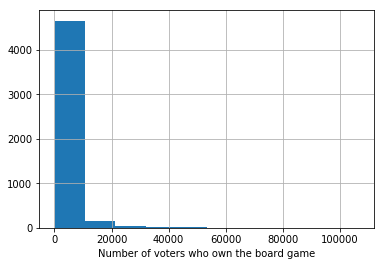

In [16]:
#ownership
#the more the number of people owning it, the critical the game gets
df['owned'].hist()
xlabel("Number of voters who own the board game")

print df['owned'].quantile([0,0.25,0.5,0.75,0.95,0.99,1])

df['owned_bucket'] = pd.qcut(df['owned'],3)
cdf = pd.crosstab(df['owned_bucket'],df['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('owned_bucket',ascending = True)
#classics and younger games are loved by game lovers

cdf = pd.crosstab(df['owned_bucket'],df['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('owned_bucket',ascending = True)

## Number of votes

avg_rating_range   detractors  promoters        NPS
num_votes_bucket                                   
(99.999, 173.0]      9.705819  15.853659   6.147839
(173.0, 241.0]      10.006442   9.756098  -0.250344
(241.0, 328.0]      10.113807   7.723577  -2.390230
(328.0, 432.6]      10.070861   8.130081  -1.940780
(432.6, 602.0]      10.307065   4.471545  -5.835520
(602.0, 847.0]      10.242645   5.691057  -4.551589
(847.0, 1272.4]     10.135280   4.878049  -5.257231
(1272.4, 2059.6]    10.049388  10.162602   0.113214
(2059.6, 4263.2]     9.813184  12.601626   2.788442
(4263.2, 74261.0]    9.555508  20.731707  11.176199


geek_rating_range,detractors,promoters,NPS
num_votes_bucket,,,
"(99.999, 173.0]",6.248658,81.300813,75.052155
"(173.0, 241.0]",9.705819,15.447154,5.741335
"(241.0, 328.0]",10.350011,3.252033,-7.097978
"(328.0, 432.6]",10.500322,0.000000,-10.500322
"(432.6, 602.0]",10.543268,0.000000,-10.543268
"(602.0, 847.0]",10.543268,0.000000,-10.543268
"(847.0, 1272.4]",10.392957,0.000000,-10.392957
"(1272.4, 2059.6]",10.586214,0.000000,-10.586214
"(2059.6, 4263.2]",10.478849,0.000000,-10.478849


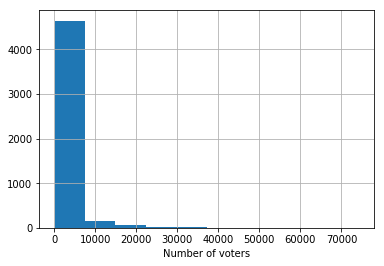

In [17]:
#num_votes
#the more the number of votes, higher the number of promoters for it
df['num_votes'].hist()
xlabel("Number of voters")

df['num_votes_bucket'] = pd.qcut(df['num_votes'],10)
cdf = pd.crosstab(df['num_votes_bucket'],df['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('num_votes_bucket',ascending = True)
#classics and younger games are loved by game lovers

cdf = pd.crosstab(df['num_votes_bucket'],df['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('num_votes_bucket',ascending = True)

### Penetration ratio

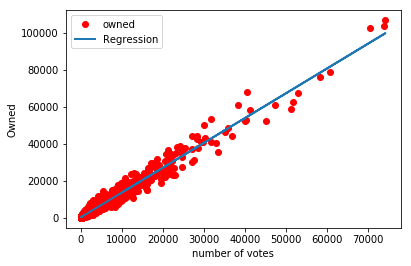

In [18]:
import statsmodels.api as sm
from patsy import dmatrices

y, X = dmatrices('owned ~ num_votes', df, return_type='dataframe')
result = sm.OLS(y, X).fit()
slope = result.params['num_votes']
intercept = result.params['Intercept']
predicted = df['num_votes'] * slope + intercept
regression_predictions = Series(predicted.values,
                                index=df['num_votes'])

#owned is if user owns or not
plot(df['num_votes'],df['owned'],marker='o', color='red', linestyle='None')
regression_predictions.plot(label='Regression', linewidth=2)
legend(numpoints=1, loc='best')
xlabel('number of votes')
ylabel('Owned')
show()

0.00    0.366071
0.25    1.416186
0.50    1.786008
0.75    2.345974
0.95    3.566182
0.99    4.945137
1.00    9.195122
Name: penetration_ratio, dtype: float64
avg_rating_range  detractors  promoters        NPS
pen_ratio_bucket                                  
(0.365, 1.179]     10.264119   5.284553  -4.979566
(1.179, 1.341]     10.350011   3.252033  -7.097978
(1.341, 1.49]      10.027915   9.349593  -0.678321
(1.49, 1.644]      10.307065   4.065041  -6.242024
(1.644, 1.786]     10.135280   7.317073  -2.818207
(1.786, 1.956]     10.242645   5.691057  -4.551589
(1.956, 2.194]     10.027915   9.349593  -0.678321
(2.194, 2.537]      9.705819  15.447154   5.741335
(2.537, 3.05]       8.975735  29.674797  20.699061
(3.05, 9.195]       9.963496  10.569106   0.605610


geek_rating_range,detractors,promoters,NPS
pen_ratio_bucket,,,
"(0.365, 1.179]",10.264119,5.284553,-4.979566
"(1.179, 1.341]",9.555508,18.292683,8.737175
"(1.341, 1.49]",9.727292,15.040650,5.313358
"(1.49, 1.644]",9.233412,24.390244,15.156832
"(1.644, 1.786]",10.221172,5.691057,-4.530116
"(1.786, 1.956]",9.254885,24.390244,15.135359
"(1.956, 2.194]",10.371484,2.845528,-7.525955
"(2.194, 2.537]",10.435903,1.626016,-8.809887
"(2.537, 3.05]",10.478849,1.219512,-9.259337


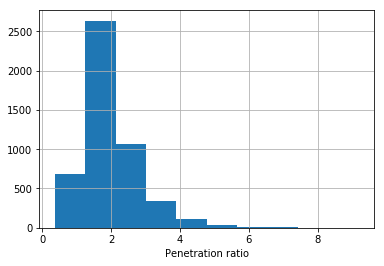

In [19]:
#Penetration ratio
# Higher the number of voters owning the game, better rating
df['penetration_ratio'] = df['owned'] / df['num_votes']
df['penetration_ratio'].hist()
xlabel("Penetration ratio")
print df['penetration_ratio'].quantile([0,0.25,0.5,0.75,0.95,0.99,1])

df['pen_ratio_bucket'] = pd.qcut(df['penetration_ratio'],10)
cdf = pd.crosstab(df['pen_ratio_bucket'],df['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('pen_ratio_bucket',ascending = True)
#classics and younger games are loved by game lovers

cdf = pd.crosstab(df['pen_ratio_bucket'],df['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('pen_ratio_bucket',ascending = True)

## Trees

Create popular and not popular based on 95th percentile of avg_rating
Going to create dummy for top categories, mechanics and designer
Other vars: avg_time, age, num_votes, min players, max players, pen ratio

In [20]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
import warnings
%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [21]:
df['popular'] = 1 * (df['avg_rating'] >=df['avg_rating'].quantile(0.95))
print df.columns.values
df['popular'].value_counts()

['rank' 'bgg_url' 'game_id' 'names' 'min_players' 'max_players' 'avg_time'
 'min_time' 'max_time' 'year' 'avg_rating' 'geek_rating' 'num_votes'
 'image_url' 'age' 'mechanic' 'owned' 'category' 'designer' 'weight'
 'avg_rating_range' 'geek_rating_range' 'num_players' 'avg_time_bucket'
 'age_bucket' 'weight_bucket' 'mechanic_c' 'category_c' 'designer_c'
 'owned_bucket' 'num_votes_bucket' 'penetration_ratio' 'pen_ratio_bucket'
 'popular']


0    4657
1     246
Name: popular, dtype: int64

In [22]:
Y, X = dmatrices('popular ~ 0 + min_players + max_players + age + weight + penetration_ratio', df, return_type='dataframe')
y = Y['popular'].values
X[:5]

,min_players,max_players,age,weight,penetration_ratio
0,1.0,4.0,12.0,3.7720,1.851133
1,2.0,4.0,13.0,2.8056,1.622249
2,2.0,4.0,14.0,4.3538,1.324750
3,2.0,2.0,13.0,3.5446,1.373325
4,1.0,5.0,12.0,3.2465,1.277360


In [24]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #random_state is seed

# Create the folds in the training data
kfold = StratifiedKFold(n_splits=10, shuffle=True)

# Iterate over max_depth
for max_depth in [1, 2, 3, 4, 5]:
    model3 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(model3, X_train, y_train, cv=kfold)
    print 'max_depth={} scores={} avg_score={}'.format(max_depth, scores, scores.mean())

max_depth=1 scores=[0.94767442 0.94767442 0.94767442 0.94767442 0.94767442 0.94767442
 0.9502924  0.9502924  0.9502924  0.9502924 ] avg_score=0.948721610227
max_depth=2 scores=[0.94767442 0.94767442 0.94767442 0.94767442 0.94767442 0.94767442
 0.9502924  0.9502924  0.9502924  0.9502924 ] avg_score=0.948721610227
max_depth=3 scores=[0.94767442 0.94767442 0.94767442 0.94767442 0.94767442 0.94767442
 0.94736842 0.94736842 0.9502924  0.9502924 ] avg_score=0.948136814905
max_depth=4 scores=[0.94476744 0.94767442 0.93895349 0.94476744 0.94767442 0.94476744
 0.92690058 0.94736842 0.9502924  0.95321637] avg_score=0.944638242894
max_depth=5 scores=[0.94186047 0.93023256 0.94767442 0.95348837 0.94186047 0.94186047
 0.94444444 0.9502924  0.94152047 0.94444444] avg_score=0.943767849857


In [40]:
model = tree.DecisionTreeClassifier(criterion='entropy',max_depth=4)
result = model.fit(X_train, y_train)

prediction_train = model.predict(X_train)
print metrics.accuracy_score(y_train, prediction_train)

prediction = model.predict(X_test)
print metrics.accuracy_score(y_test, prediction)

0.9507575757575758
0.9510537049626104


In [29]:
#import os     
#os.environ["PATH"] += os.pathsep + 'C:\\Users\\abhin\\Anaconda2\\Library\\bin\\graphviz'

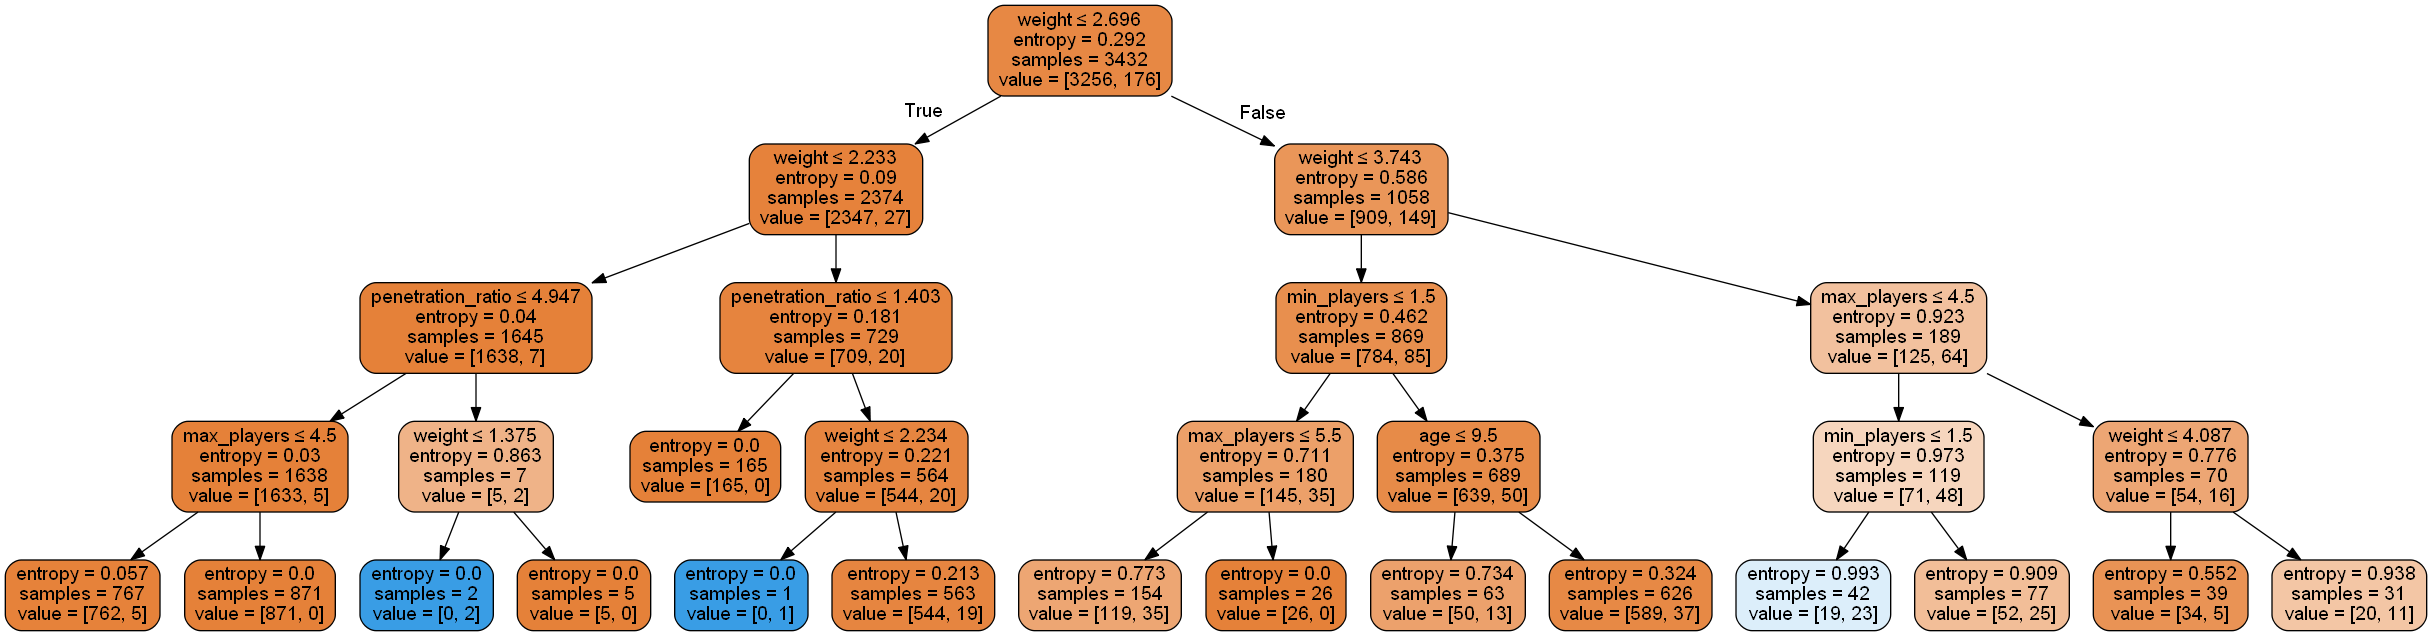

In [41]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X.columns.values)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [34]:
from StringIO import StringIO
import pydot_ng
dot_data = StringIO()

tree.export_graphviz(model, out_file=dot_data, feature_names=X.columns.values)
pydot_ng.graph_from_dot_data(dot_data.getvalue()).write_png('test.png')

True